In [50]:
# Licensed under the Apache License, Version 2.0 (the "License"); you may
# not use this file except in compliance with the License. You may obtain
# a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS, WITHOUT
# WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the
# License for the specific language governing permissions and limitations
# under the License.

# Creating a Scalable Recommender with Apache Spark & Apache Solr

In this notebook, you will create a recommendation engine using Spark and Solr. Using some movie rating data,
you will train a collaborative filtering model in Spark and export the trained model to Solr. Once exported, 
you can test your recommendations by querying Solr and displaying the results.

### _Prerequisites_

The notebook assumes you have installed Solr, the Solr vector-scoring plugin, Apache Spark and the Solr Spark connector detailed in the [setup steps](https://github.com/MLnick/elasticsearch-spark-recommender-demo/tree/master#steps).

> _Optional:_

> In order to display the images in the recommendation demo, you will need to access [The Movie Database (TMdb) API](https://www.themoviedb.org/documentation/api). Please follow the [instructions](https://developers.themoviedb.org/3/getting-started) to get an API key.

## Overview

You will work through the following steps

1. Prepare the data
2. Use the Solr Spark connector to save it to Solr
3. Load ratings data and train a collaborative filtering recommendation model using Spark MLlib
3. Save the model to Solr
4. Show recommendations using Solr vector scoring plugin

## Step 1: Prepare the data

* This notebook uses the "small" version of the latest MovieLens movie rating dataset, containing about 100,000 ratings, 9,000 movies and 700 users
* The latest version of the data can be downloaded at https://grouplens.org/datasets/movielens/latest/
* Download the `ml-latest-small.zip` file and unzip it to a suitable location on your system.

The folder should contain a number of CSV files. We will be using the following files:
* `ratings.csv` - movie rating data
* `links.csv` - external database ids for each movie
* `movies.csv` - movie title and genres

In [51]:
!!pip install tmdbsimple --user
!!pip install solrcloudpy --user
!!pip install simplejson --user

['Requirement already satisfied: simplejson in /user-home/1001/.local/lib/python2.7/site-packages (3.15.0)',
 "mxnet 1.1.0 has requirement numpy<=1.13.3, but you'll have numpy 1.14.1 which is incompatible."]

In [8]:
%load_ext sparkmagic.magics
import dsx_core_utils
dsx_core_utils.setup_livy_sparkmagic()
%reload_ext sparkmagic.magics

The sparkmagic.magics extension is already loaded. To reload it, use:
  %reload_ext sparkmagic.magics
success configuring sparkmagic livy.


In [ ]:
%spark delete -s $edgenode

In [10]:
edgenode="PROVIDE_HOST_NAME_OF_EDGE_SERVER"
dsxhiURL="PROVIDE_DSXHI_URL"
webhdfsURL=dsxhiURL + "webhdfs/v1/"
livyURL=dsxhiURL + "livy/v1/"
livy2URL=dsxhiURL + "livy2/v1/"

%spark add -s $edgenode -l python -u $livy2URL

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
68,application_1528313432729_0007,pyspark,idle,Link,Link,✔


SparkSession available as 'spark'.


In [11]:
# first import a few utility methods that we'll use later on
from IPython.display import Image, HTML, display
from urllib2 import *
import simplejson as json
import requests as requests
import sys
from solrcloudpy.connection import SolrConnection

In [12]:
%%spark
# first import a few utility methods that we'll use later on
from IPython.display import Image, HTML, display
from urllib2 import *
import simplejson as json
import requests as requests
import sys
import paramiko
from solrcloudpy.connection import SolrConnection
# check PySpark is running
spark

### Load rating and movie data

**Ratings**

The ratings data consists of around 100,000 ratings given by users to movies. Each row of the `DataFrame` consists of a `userId`, `movieId` and `timestamp` for the event, together with the `rating` given by the user to the movie

In [ ]:
%%spark
# if you unzipped the data to a different location than that specified in the Journey setup steps
# you can change the path below to point to the correct location
PATH_TO_DATA = "PATH_TO_YOUR_DATA"
# load ratings data
ratings = spark.read.csv(PATH_TO_DATA + "/ratings.csv", header=True, inferSchema=True)
ratings.cache()
print("Number of ratings: %i" % ratings.count())
print("Sample of ratings:")
ratings.show(5)

You will see that the `timestamp` field is a UNIX timestamp in seconds. In the following cell, a spark built-in function `from_unix_timestap` is called to convert the timestamp to the format solr acccepts. More information on splr date formats can be found in https://lucene.apache.org/solr/guide/6_6/working-with-dates.html 

In [14]:
%%spark
from pyspark.sql import functions as F
ratings = ratings.select("userId", "movieId", "rating", F.from_unixtime("timestamp").alias("timestamp"))
ratings.show(5)

+------+-------+------+-------------------+
|userId|movieId|rating|          timestamp|
+------+-------+------+-------------------+
|     1|     31|   2.5|2009-12-13 18:52:24|
|     1|   1029|   3.0|2009-12-13 18:52:59|
|     1|   1061|   3.0|2009-12-13 18:53:02|
|     1|   1129|   2.0|2009-12-13 18:53:05|
|     1|   1172|   4.0|2009-12-13 18:53:25|
+------+-------+------+-------------------+
only showing top 5 rows

**Movies**

The file `movies.csv` contains the `movieId`, `title` and `genres` for each movie. As you can see, the `genres` field is a bit tricky to use, as the genres are in the form of one string delimited by the `|` character: `Adventure|Animation|Children|Comedy|Fantasy`.

In [15]:
%%spark
# load raw data from CSV
raw_movies = spark.read.csv(PATH_TO_DATA + "/movies.csv", header=True, inferSchema=True)
print("Raw movie data:")
raw_movies.show(5, truncate=False)

Raw movie data:
+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genres                                     |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)|Comedy                                     |
+-------+----------------------------------+-------------------------------------------+
only showing top 5 rows

Create a `DataFrame` user-defined function (UDF) to extract this delimited string into a list of genres.

In [16]:
%%spark
from pyspark.sql.functions import udf
from pyspark.sql.types import *
# define a UDF to convert the raw genres string to an array of genres and lowercase
extract_genres = udf(lambda x: x.lower().split("|"), ArrayType(StringType()))
# test it out
raw_movies.select("movieId", "title", extract_genres("genres").alias("genres")).show(5, False)

+-------+----------------------------------+-------------------------------------------------+
|movieId|title                             |genres                                           |
+-------+----------------------------------+-------------------------------------------------+
|1      |Toy Story (1995)                  |[adventure, animation, children, comedy, fantasy]|
|2      |Jumanji (1995)                    |[adventure, children, fantasy]                   |
|3      |Grumpier Old Men (1995)           |[comedy, romance]                                |
|4      |Waiting to Exhale (1995)          |[comedy, drama, romance]                         |
|5      |Father of the Bride Part II (1995)|[comedy]                                         |
+-------+----------------------------------+-------------------------------------------------+
only showing top 5 rows

Ok, that looks better!

You may also notice that the movie titles contain the year of release. It would be useful to have that as a field in your search index for filtering results (say you want to filter our recommendations to include only more recent movies).

Create a UDF to extract the release year from the title using a Python regular expression.

In [17]:
%%spark
import re
# define a UDF to extract the release year from the title, and return the new title and year in a struct type
def extract_year_fn(title):
    result = re.search("\(\d{4}\)", title)
    try:
        if result:
            group = result.group()
            year = group[1:-1]
            start_pos = result.start()
            title = title[:start_pos-1]
            return (title, year)
        else:
            return (title, 1970)
    except:
        print(title)

extract_year = udf(extract_year_fn,\
                   StructType([StructField("title", StringType(), True),\
                               StructField("release_date", StringType(), True)]))
    
# test out our function
s = "Jumanji (1995)"
extract_year_fn(s)

('Jumanji', '1995')

Ok the function works! Now create a new `DataFrame` with the cleaned-up titles, release dates and genres of the movies.

In [18]:
%%spark
movies = raw_movies.select(
    "movieId", extract_year("title").title.alias("title"),\
    extract_year("title").release_date.alias("release_date"),\
    extract_genres("genres").alias("genres"))
print("Cleaned movie data:")
movies.show(5, truncate=False)

Cleaned movie data:
+-------+---------------------------+------------+-------------------------------------------------+
|movieId|title                      |release_date|genres                                           |
+-------+---------------------------+------------+-------------------------------------------------+
|1      |Toy Story                  |1995        |[adventure, animation, children, comedy, fantasy]|
|2      |Jumanji                    |1995        |[adventure, children, fantasy]                   |
|3      |Grumpier Old Men           |1995        |[comedy, romance]                                |
|4      |Waiting to Exhale          |1995        |[comedy, drama, romance]                         |
|5      |Father of the Bride Part II|1995        |[comedy]                                         |
+-------+---------------------------+------------+-------------------------------------------------+
only showing top 5 rows

Next, join the `links.csv` data to `movies` so that there is an id for _The Movie Database_ corresponding to each movie. You can use this id to retrieve movie poster images when displaying your recommendations later.

In [19]:
%%spark
link_data = spark.read.csv(PATH_TO_DATA + "/links.csv", header=True, inferSchema=True)
# join movies with links to get TMDB id
movie_data = movies.join(link_data, movies.movieId == link_data.movieId)\
    .select(movies.movieId, movies.title, movies.release_date, movies.genres, link_data.tmdbId)
num_movies = movie_data.count()
print("Cleaned movie data with tmdbId links:")
movie_data.show(5, truncate=False)

Cleaned movie data with tmdbId links:
+-------+---------------------------+------------+-------------------------------------------------+------+
|movieId|title                      |release_date|genres                                           |tmdbId|
+-------+---------------------------+------------+-------------------------------------------------+------+
|1      |Toy Story                  |1995        |[adventure, animation, children, comedy, fantasy]|862   |
|2      |Jumanji                    |1995        |[adventure, children, fantasy]                   |8844  |
|3      |Grumpier Old Men           |1995        |[comedy, romance]                                |15602 |
|4      |Waiting to Exhale          |1995        |[comedy, drama, romance]                         |31357 |
|5      |Father of the Bride Part II|1995        |[comedy]                                         |11862 |
+-------+---------------------------+------------+------------------------------------------------

> **_Optional_**

> Run the below cell to test your access to TMDb API. You should see the _Toy Story_ movie poster displayed inline.

> To install the Python package run `pip install tmdbsimple`

In [20]:
%%spark
try:
    import tmdbsimple as tmdb
    # replace this variable with your actual TMdb API key
    tmdb.API_KEY='YOUR_TMDB_API_KEY'
    print("Successfully imported tmdbsimple!")
    # base URL for TMDB poster images
    IMAGE_URL = 'https://image.tmdb.org/t/p/w500'
    movie_id = movie_data.first().tmdbId
    movie_info = tmdb.Movies(movie_id).info()
    movie_poster_url = IMAGE_URL + movie_info['poster_path']
    # display(Image(movie_poster_url, width=200))
    selectQuery = "SELECT '%s'" % (movie_poster_url)
    poster_df = spark.sql(selectQuery)
    poster_df.registerTempTable('poster')
except Exception:
    print("Cannot import tmdbsimple, no movie posters will be displayed!")

Successfully imported tmdbsimple!

In [21]:
%%spark -c sql -o poster_url -q
select * from poster

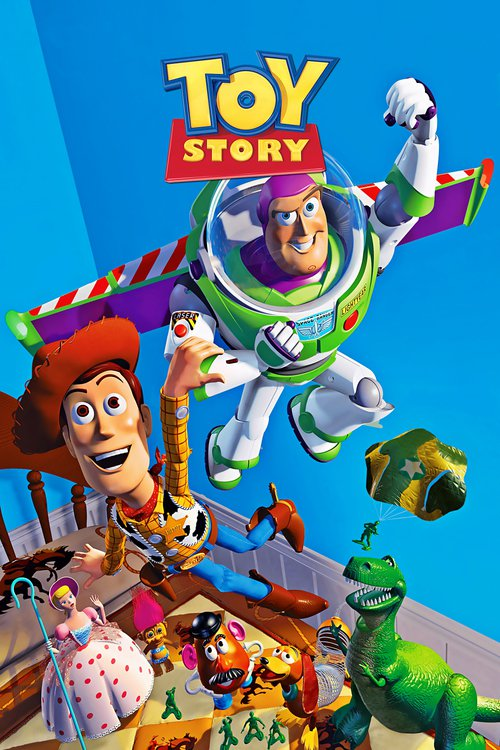

In [22]:
display(Image(poster_url.iloc[0][0], width=200))

### Setting of global variables. 

*** Fill in the following variables 


In [23]:
# Host name where solr is installed
SOLR_HOST = 'SOLR_HOST_NAME'
# The port solr server is listening at.
SOLR_PORT = '8983'
SOLR_HOST_PORT = SOLR_HOST + ':' + SOLR_PORT
SOLR_URL = 'http://' + SOLR_HOST_PORT + '/solr'

In [24]:
%%spark
# Install directory needs to be specified to aid in moving solr config files to
# zookeeper. This is a requirement in solr cloud setup.
SOLR_INSTALL_DIR = 'SOLR_INSTALL_DIR'
# Host name where solr is installed
SOLR_HOST = 'SOLR_HOST_NAME'
# The port solr server is listening at.
SOLR_PORT = '8983'
# Host name where zookeeper is installed.
ZKHOST = 'ZOOKEPER_HOST'
# Zookeeper port.
ZKPORT = '2181'
# Required in order to ssh to the machine where solr server is installed in order
# to copy the solr configuration files into zookeeper. If you don't want to
# do this step from the notebook, then you can do this outside the notebook and
# do the remaining steps like creating collection and setting up schemas from notebook.
SSHUSER = 'SSH_USER'
SSHPASSWORD = 'SSH_PASSWORD'

In [25]:
%%spark
# Derived variables used in the following cells
SOLR_HOST_PORT = SOLR_HOST + ':' + SOLR_PORT
SOLR_URL = 'http://' + SOLR_HOST_PORT + '/solr'
SOLR_ADMIN_URL = SOLR_URL + '/admin/'
SCHEMA_URL = SOLR_URL + '/solr/admin/'
ZK_URL = ZKHOST + ':' + ZKPORT + '/solr'
json_response = '&wt=json'

In [26]:
### Utility functions that helps in performing admin functions against SOLR.

In [27]:
%%spark
def executeSshCommand(command):
  ssh = None
  try:
      ssh = paramiko.SSHClient()
      ssh.load_system_host_keys()
      ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
      ssh.connect(SOLR_HOST, username=SSHUSER, password=SSHPASSWORD)
      ssh_stdin, ssh_stdout, ssh_stderr = ssh.exec_command(command)
      # print(ssh_stdout)
      # print(ssh_stderr)
  finally:
      if ssh:
         ssh.close()

def createJKConfig(collectionName):
  cmd = (SOLR_INSTALL_DIR + '/solr/server/scripts/cloud-scripts' +
        '/zkcli.sh -zkhost ' + ZK_URL +
        ' -cmd upconfig -confdir ' +
        SOLR_INSTALL_DIR + '/' + 'solr/server/solr/configsets/data_driven_schema_configs/conf/ -confname ' + collectionName
        )
  executeSshCommand(cmd)
    
def deleteJKConfig(collectionName):
  dirToClear = 'configs/collectionName'
  cmd = (SOLR_INSTALL_DIR + '/solr/server/scripts/cloud-scripts' +
        '/zkcli.sh -zkhost ' + ZK_URL +
        ' -cmd clear ' + dirToClear
        )
  executeSshCommand(cmd)

def displayStatus():
  request = SOLR_ADMIN_URL + 'info/system?'+ json_response
  try:
    connection = urlopen(request)
    response = json.load(connection)
    responseCode = response["responseHeader"]["status"]
    if responseCode == 0:
      print(response)
    else:
      print("Error: ", responseCode)
  except URLError, e:
    print e.reason

def createCollection(collectionName):
  time.sleep(2)
  action_string = 'collections?action=CREATE&name=' + \
                  collectionName + \
                  '&numShards=1&replicationFactor=1'
  request = SOLR_ADMIN_URL + action_string + json_response
  try:
    connection = urlopen(request)
    response = json.load(connection)
    responseCode = response["responseHeader"]["status"]
    if responseCode == 0:
      print("Successfully created collection: ", collectionName)
    else:
      print("Error: ", responseCode)
  except URLError, e:
    pass 

def dropCollection(collectionName):
  action_string = 'collections?action=DELETE&name=' + collectionName
  request = SOLR_ADMIN_URL + action_string + json_response
  try:
    connection = urlopen(request)
    response = json.load(connection)
    responseCode = response["responseHeader"]["status"]
    if responseCode == 0:
      print("Successfully removed collection: ", collectionName)
    else:
      print("Error: ", responseCode)
  except URLError, e:
    print e.reason
  deleteJKConfig(collectionName)

def setupSchema():
  try:
    dropCollection('ratings')
  except:
    pass
  try:
    dropCollection('users')
  except:
    pass
  try:
    dropCollection('movies')
  except:
    pass
  try:
    dropCollection('movies_vector')
  except:
    pass
  createCollection('ratings')
  createCollection('users')
  createCollection('movies')
  createCollection('movies_vector')
  print("Created collections : [ratings, users, movies, movies_vector]")
  ratings_schema = """{
    "add-field":{
       "name":"timestamp",
       "type":"date",
       "stored":"true",
       "indexed":"true"
     },
    "add-field":{
       "name":"userId",
       "type":"int",
       "stored":"true",
       "indexed":"true"
     },
    "add-field":{
       "name":"movieId",
       "type":"int",
       "stored":"true",
       "indexed":"true"
     },
    "add-field":{
       "name":"rating",
       "type":"double",
       "stored":"true",
       "indexed":"true"
     }
  }"""
  users_schema = """{
    "add-field":{
       "name":"id",
       "type":"int",
       "stored":"true",
       "indexed":"true"
     },
    "add-field":{
       "name":"factor",
       "type":"VectorField",
       "termOffsets":"true",
       "termPositions":"true",
       "termVectors":"true",
       "multiValued":"true",
       "stored":"true",
       "indexed":"true"
     },
    "add-field":{
       "name":"version",
       "type":"string",
       "stored":"true",
       "indexed":"true",
       "multiValued":"true"
     },
    "add-field":{
       "name":"timestamp",
       "type":"date",
       "stored":"true",
       "indexed":"true"
     }
  }"""
  movies_schema = """{
    "add-field":{
       "name":"movieId",
       "type":"int",
       "stored":"true",
       "indexed":"true"
     },
    "add-field":{
       "name":"tmdbId",
       "type":"string",
       "stored":"true",
       "indexed":"true",
       "multiValued":"true"
     },
    "add-field":{
       "name":"title",
       "type":"text_general",
       "stored":"true",
       "indexed":"true"
     },
    "add-field":{
       "name":"genres",
       "type":"string",
       "stored":"true",
       "indexed":"true",
       "multiValued":"true"
     },
    "add-field":{
       "name":"release_date",
       "type":"int",
       "stored":"true",
       "indexed":"true"
     },
    "add-field":{
       "name":"factor",
       "type":"VectorField",
       "termOffsets":"true",
       "termPositions":"true",
       "termVectors":"true",
       "multiValued":"true",
       "stored":"true",
       "indexed":"true"
     },
    "add-field":{
       "name":"version",
       "type":"string",
       "stored":"true",
       "indexed":"true",
       "multiValued":"true"
     },
    "add-field":{
       "name":"timestamp",
       "type":"date",
       "stored":"true",
       "indexed":"true"
    }
  }"""
  mappings_schema_url = SOLR_URL + '/ratings/schema'
  headers = {'content-type': 'application/json'}
  ratings_status = requests.post(mappings_schema_url, data=ratings_schema, headers=headers)
  if ratings_status.status_code == requests.codes.ok:
     print("Successfully registered schema for collection ratings")
  else:
     ratings_status.raise_for_status()
  users_schema_url = SOLR_URL + '/users/schema'
  users_status  = requests.post(users_schema_url, data=users_schema, headers=headers)
  if users_status.status_code == requests.codes.ok:
     print("Successfully registered schema for collection users")
  else:
     users_status.raise_for_status()
  movies_schema_url = SOLR_URL + '/movies/schema'
  movies_status = requests.post(movies_schema_url, data=movies_schema, headers=headers)
  if movies_status.status_code == requests.codes.ok:
     print("Successfully registered schema for collection movies")
  else:
     movies_status.raise_for_status()
  movies_vector_schema_url = SOLR_URL + '/movies_vector/schema'
  movies_vector_status = requests.post(movies_vector_schema_url, data=movies_schema, headers=headers)
  if movies_vector_status.status_code == requests.codes.ok:
     print("Successfully registered schema for collection movies_vector")
  else:
     movies_vector_status.raise_for_status()     

def commit(conn, collection):
    conn[collection].commit()

def prettyPrint(docs):
    for x in docs:
       print(json.dumps(x))

## Step 2: Load data into Solr

Now that you have your dataset processed and prepared, you will load it into Solr.

_Note:_ for the purposes of this demo notebook you have started with an existing example dataset and will load that into Solr. In practice you may write your event data as well as user and item metadata from your application directly into Solr.

First test that your Solr instance is running and you can connect to it using the Solr Admin API.

In [ ]:
%%spark
displayStatus()

### Create an Solr collections with schema mappings for users, movies and rating events

Creates the solr collections and explicitly author their schema. While solr supports dynamic mapping, it's advisable to specify the schema mapping explicitly if you know what your data looks like.

For the purposes of your recommendation engine, this is also necessary so that you can specify a custom analyzer for the field that will hold the recommendation "model" (that is, the factor vectors). This will ensure the vector-scoring plugin will work correctly.

> _Note_ This notebook does not go into detail about the underlying scoring mechanism or the relevant Solr internals. See the talks and slides in the [Journey Links section](https://github.com/MLnick/elasticsearch-spark-recommender-demo/blob/master/README.md#links) for more detail.

__References:__
* [Create index request](https://www.elastic.co/guide/en/elasticsearch/reference/current/indices-create-index.html)
* [Delimited payload filter](https://www.elastic.co/guide/en/elasticsearch/reference/2.4/analysis-delimited-payload-tokenfilter.html)
* [Term vectors](https://www.elastic.co/guide/en/elasticsearch/reference/2.4/docs-termvectors.html#_term_information)
* [Mapping](https://www.elastic.co/guide/en/elasticsearch/reference/2.4/mapping.html)

> **Note**

> Please note that, the following cell drops the collections first and then recreates them with appropriate schema. Please make sure you don't have existing collections with the same name. You may inadvertently delete the collections with the following step.

Now you're ready to create the collections and author their respective schema definitions.

In [29]:
%%spark
setupSchema()
conn = SolrConnection(SOLR_HOST_PORT, version="6.6.0")

('Successfully removed collection: ', 'ratings')
('Successfully removed collection: ', 'users')
('Successfully removed collection: ', 'movies')
('Successfully removed collection: ', 'movies_vector')
('Successfully created collection: ', 'ratings')
('Successfully created collection: ', 'users')
('Successfully created collection: ', 'movies')
('Successfully created collection: ', 'movies_vector')
Created collections : [ratings, users, movies, movies_vector]
Successfully registered schema for collection ratings
Successfully registered schema for collection users
Successfully registered schema for collection movies
Successfully registered schema for collection movies_vector

In [30]:
conn = SolrConnection(SOLR_HOST_PORT, version="6.6.0")

### Load Ratings and Movies DataFrames into Solr

First you will write the ratings data to Solr. Notice that you can simply use the Spark Solr connector to write a `DataFrame` with the native Spark datasource API by specifying `format("solr")`

In [31]:
%%spark
# write ratings data
ratings.write.format("solr").option("zkhost", ZK_URL).option("collection", "ratings").save("ratings")
commit(conn, "ratings")
# check write went ok
print("Dataframe count: %d" % ratings.count())
res = conn["ratings"].search({'q':'*:*'})
print("Solr index count:  %d" % res.result.response.numFound)

Dataframe count: 100004
Solr index count:  100004

In [32]:
%%spark
# test things out by retrieving a few rating event documents from Solr
from solrcloudpy.parameters import SearchOptions
se = SearchOptions()
se.commonparams.q("*").rows(3)
res = conn["ratings"].search(se)
prettyPrint(res.result.response.docs)
print("Number of documents returned from Query %d" % len(res.result.response.docs))

{"rating": 2.5, "movieId": 31, "timestamp": "2009-12-13T18:52:24Z", "userId": 1, "_version_": 1602571901399465984, "id": "aba4cbb1-c87c-4fb0-b45e-9b903ed73ad3"}
{"rating": 3.0, "movieId": 1029, "timestamp": "2009-12-13T18:52:59Z", "userId": 1, "_version_": 1602571901411000320, "id": "3c156a93-2130-476f-a6db-919f4b3786ce"}
{"rating": 3.0, "movieId": 1061, "timestamp": "2009-12-13T18:53:02Z", "userId": 1, "_version_": 1602571901411000321, "id": "33efb74d-589e-4653-b482-f8cceea8d1d3"}
Number of documents returned from Query 3

Since you've indexed the rating event data into Solr, you can use all the capabilities of a search engine to query the data. For example, you could count the number of ratings events in a given date range using Solr's date math in a query string:

In [33]:
%%spark
se = SearchOptions()
se.commonparams.q("timestamp:[2016-01-01T00:00:00Z  TO 2016-02-01T23:59:59Z]")
res = conn["ratings"].search(se)
prettyPrint(res.result.response.docs)
print("Number of documents returned from Query %d" % len(res.result.response.docs))

{"rating": 4.0, "movieId": 111, "timestamp": "2016-01-01T20:25:54Z", "userId": 62, "_version_": 1602571903162122244, "id": "421630a1-a456-43a6-9a66-e8d5384ce598"}
{"rating": 4.0, "movieId": 6016, "timestamp": "2016-01-01T20:21:32Z", "userId": 62, "_version_": 1602571903164219394, "id": "6e92b470-12a4-4d8c-989c-47a465e10ee0"}
{"rating": 4.0, "movieId": 48774, "timestamp": "2016-01-20T11:29:34Z", "userId": 62, "_version_": 1602571903164219396, "id": "f34e7528-4d2d-4317-870f-79c4bcfed956"}
{"rating": 3.5, "movieId": 49530, "timestamp": "2016-01-15T20:03:09Z", "userId": 62, "_version_": 1602571903165267968, "id": "8a768472-a5a0-411b-98e4-430f4a41bd39"}
{"rating": 4.5, "movieId": 68157, "timestamp": "2016-01-01T20:25:22Z", "userId": 62, "_version_": 1602571903165267971, "id": "767717e9-9b75-4060-a558-9569cf099f0d"}
{"rating": 4.5, "movieId": 68237, "timestamp": "2016-01-01T20:17:08Z", "userId": 62, "_version_": 1602571903165267972, "id": "0c3333ec-d60e-4432-b0a1-bb7e9b47ad5c"}
{"rating": 3.

Next write the movie metadata

In [34]:
%%spark
# write movie data
movie_data.write.format("solr").option("zkhost", ZK_URL).option("collection", "movies").save("movies")
commit(conn, "movies")
# check load went ok
print("Movie DF count: %d" % movie_data.count())
res = conn["movies"].search({'q':'*:*'})
print("Solr index count:  %d" % res.result.response.numFound)

Movie DF count: 9125
Solr index count:  9125

Again you can harness the power of search to query the movie metadata:

In [35]:
%%spark
# test things out by searching for movies containing "matrix" in the title
se = SearchOptions()
se.commonparams.q("title:matrix").rows(3)
res = conn["movies"].search(se)
prettyPrint(res.result.response.docs)
print("Number of documents returned from Query %d" % len(res.result.response.docs))

{"genres": ["action", "sci-fi", "thriller"], "movieId": 2571, "title": ["Matrix, The"], "release_date": 1999, "tmdbId": ["603"], "_version_": 1602571924008861704, "id": "57c1eb87-2b09-49cb-b084-7b1268349d86"}
{"genres": ["action", "adventure", "sci-fi", "thriller", "imax"], "movieId": 6365, "title": ["Matrix Reloaded, The"], "release_date": 2003, "tmdbId": ["604"], "_version_": 1602571924188168193, "id": "c2878d05-cc53-4dc7-853c-18c06eb81e59"}
{"genres": ["action", "adventure", "sci-fi", "thriller", "imax"], "movieId": 6934, "title": ["Matrix Revolutions, The"], "release_date": 2003, "tmdbId": ["605"], "_version_": 1602571924200751120, "id": "6793a7df-3a8d-41d3-a9e9-69bdad5fb8c6"}
Number of documents returned from Query 3

## Step 3: Train a recommmender model on the ratings data

Your data is now stored in Solr and you will use the ratings data to build a collaborative filtering recommendation model.

[Collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering) is a recommendation approach that is effectively based on the "wisdom of the crowd". It makes the assumption that, if two people share similar preferences, then the things that one of them prefers could be good recommendations to make to the other. In other words, if user A tends to like certain movies, and user B shares some of these preferences with user A, then the movies that user A likes, that user B _has not yet seen_, may well be movies that user B will also like.

In a similar manner, we can think about _items_ as being similar if they tend to be rated highly by the same people, on average. 

Hence these models are based on the combined, collaborative preferences and behavior of all users in aggregate. They tend to be very effective in practice (provided you have enough preference data to train the model). The ratings data you have is a form of _explicit preference data_, perfect for training collaborative filtering models.

### Alternating Least Squares

Alternating Least Squares (ALS) is a specific algorithm for solving a type of collaborative filtering model known as [matrix factorization (MF)](https://en.wikipedia.org/wiki/Matrix_decomposition). The core idea of MF is to represent the ratings as a _user-item ratings matrix_. In the diagram below you will see this matrix on the left (with users as _rows_ and movies as _columns_). The entries in this matrix are the ratings given by users to movies.

You may also notice that the matrix has _missing entries_ because not all users have rated all movies. In this situation we refer to the data as _sparse_.

![als-diagram.png](../doc/source/images/als-diagram.png)

MF methods aim to find two much smaller matrices (one representing the _users_ and the other the _items_) that, when multiplied together, re-construct the original ratings matrix as closely as possible. This is know as _factorizing_ the original matrix, hence the name of the technique.

The two smaller matrices are called _factor matrices_ (or _latent features_). The user and movie factor matrices are illustrated on the right in the diagram above. The idea is that each user factor vector is a compressed representation of the user's preferences and behavior. Likewise, each item factor vector is a compressed representation of the item. Once the model is trained, the factor vectors can be used to make recommendations, which is what you will do in the following sections.

__Further reading:__

* [Spark MLlib Collaborative Filtering](http://spark.apache.org/docs/latest/ml-collaborative-filtering.html)
* [Alternating Least Squares and collaborative filtering](https://datasciencemadesimpler.wordpress.com/tag/alternating-least-squares/)
* [Quora question on Alternating Least Squares](https://www.quora.com/What-is-the-Alternating-Least-Squares-method-in-recommendation-systems-And-why-does-this-algorithm-work-intuition-behind-this)

Fortunately, Spark's MLlib machine learning library has a scalable, efficient implementation of matrix factorization built in, which we can use to train our recommendation model. Next, you will use Spark's ALS to train a model on your ratings data from Solr.

In [36]:
%%spark
ratings_from_solr = spark.read.format("solr").option("zkhost", ZK_URL).option("collection", "ratings").load("ratings")
ratings_from_solr.show(5)

+--------------------+-------+------+-------------------+------+
|                  id|movieId|rating|          timestamp|userId|
+--------------------+-------+------+-------------------+------+
|0000b99e-73e3-4f9...|    230|   4.0|1996-09-19 21:19:16|   496|
|0000d190-f6d5-46d...|   1278|   5.0|2006-08-21 10:05:16|    83|
|000167b2-e363-427...|   2502|   3.5|2005-04-03 13:58:06|   417|
|000284ba-899e-42f...|   2916|   3.5|2005-03-23 05:11:30|   282|
|00046417-f6f8-430...|     16|   5.0|1996-03-30 03:12:30|   224|
+--------------------+-------+------+-------------------+------+
only showing top 5 rows

In [37]:
%%spark
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import col
als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", regParam=0.01, rank=20, seed=12)
model = als.fit(ratings_from_solr)
model.userFactors.show(5)
model.itemFactors.show(5)

+---+--------------------+
| id|            features|
+---+--------------------+
| 10|[0.3674726, 0.118...|
| 20|[-0.60201323, 0.8...|
| 30|[0.45107082, 0.01...|
| 40|[-0.23864046, -0....|
| 50|[0.44629014, 0.42...|
+---+--------------------+
only showing top 5 rows

+---+--------------------+
| id|            features|
+---+--------------------+
| 10|[0.43729877, -0.3...|
| 20|[0.99712294, 1.34...|
| 30|[0.36094037, 0.10...|
| 40|[1.3377725, -0.00...|
| 50|[0.28212664, -0.2...|
+---+--------------------+
only showing top 5 rows

## Step 4: Export ALS user and item factor vectors to Solr

Congratulations, you've trained a recommendation model! The next step is to export the model factors (shown in the `DataFrames` above) to Solr.

In order to store the model in the correct format for the index mappings set up earlier, you will need to create some utility functions. These functions will allow you to convert the raw vectors (which are equivalent to a Python list in the factor `DataFrames` above) to the correct _delimited string format_. This ensures Solr will parse the vector field in the model correctly using the delimited token filter custom analyzer you configured earlier.

You will also create a function to convert a vector and related metadata (such as the Spark model id and a timestamp) into a `DataFrame` field that matches the `model` field in the Solr index mapping.

### Utility functions for converting factor vectors

In [38]:
%%spark
from pyspark.sql.types import *
from pyspark.sql.functions import udf, lit, current_timestamp, unix_timestamp

def convert_vector(x):
    '''Convert a list or numpy array to delimited token filter format'''
    return " ".join(["%s|%s" % (i, v) for i, v in enumerate(x)])

def reverse_convert(s):
    '''Convert a delimited token filter format string back to list format'''
    return  [float(f.split("|")[1]) for f in s.split(" ")]

def vector_to_struct(x, version, ts):
    '''Convert a vector to a SparkSQL Struct with string-format vector and version fields'''
    return (convert_vector(x), version, ts)

vector_struct = udf(vector_to_struct, \
                    StructType([StructField("factor", StringType(), True), \
                                StructField("version", StringType(), True),\
                                StructField("timestamp", LongType(), True)]))

In [39]:
%%spark
# test out the vector conversion function
test_vec = model.userFactors.select("features").first().features
print(test_vec)
print()
print(convert_vector(test_vec))

[0.3674725890159607, 0.11864374577999115, 0.3943413197994232, 0.627119779586792, 0.1258048564195633, -0.43264928460121155, 0.607657253742218, -0.002352567855268717, -0.0375259667634964, -0.07540702074766159, 0.1594085991382599, -0.8177066445350647, 0.5343821048736572, -0.6135174632072449, 0.5194279551506042, 0.28479066491127014, -0.14081591367721558, -0.007298605982214212, -0.26084643602371216, -0.5528038144111633]
()
0|0.367472589016 1|0.11864374578 2|0.394341319799 3|0.627119779587 4|0.12580485642 5|-0.432649284601 6|0.607657253742 7|-0.00235256785527 8|-0.0375259667635 9|-0.0754070207477 10|0.159408599138 11|-0.817706644535 12|0.534382104874 13|-0.613517463207 14|0.519427955151 15|0.284790664911 16|-0.140815913677 17|-0.00729860598221 18|-0.260846436024 19|-0.552803814411

### Convert factor vectors to [factor, version, timestamp] form and write to Solr

In [40]:
%%spark
ver = model.uid
ts = unix_timestamp(current_timestamp())
movie_vectors = model.itemFactors.select("id", vector_struct("features", lit(ver), ts).alias("@model"))
movie_vectors.select("id", "@model.factor", "@model.version", "@model.timestamp").show(5)
user_vectors = model.userFactors.select("id", vector_struct("features", lit(ver), ts).alias("@model"))
user_vectors.select("id", "@model.factor", "@model.version", "@model.timestamp").show(5)

+---+--------------------+--------------------+----------+
| id|              factor|             version| timestamp|
+---+--------------------+--------------------+----------+
| 10|0|0.437298774719 ...|ALS_4d6198252d2f6...|1528331697|
| 20|0|0.997122943401 ...|ALS_4d6198252d2f6...|1528331697|
| 30|0|0.360940366983 ...|ALS_4d6198252d2f6...|1528331697|
| 40|0|1.33777248859 1...|ALS_4d6198252d2f6...|1528331697|
| 50|0|0.282126635313 ...|ALS_4d6198252d2f6...|1528331697|
+---+--------------------+--------------------+----------+
only showing top 5 rows

+---+--------------------+--------------------+----------+
| id|              factor|             version| timestamp|
+---+--------------------+--------------------+----------+
| 10|0|0.367472589016 ...|ALS_4d6198252d2f6...|1528331697|
| 20|0|-0.602013230324...|ALS_4d6198252d2f6...|1528331697|
| 30|0|0.451070815325 ...|ALS_4d6198252d2f6...|1528331697|
| 40|0|-0.238640457392...|ALS_4d6198252d2f6...|1528331697|
| 50|0|0.446290135384 ...|ALS_4

In [41]:
%%spark
movie_vectors.registerTempTable("movie_vector")
movie_data.registerTempTable("movie_data")

# Inner join to fill in the extra info from movie vector
movie_vector_data = spark.sql("select * from movie_data, movie_vector where movieId = id").drop("id")
movie_vector_data.registerTempTable("movie_vector_data")
movie_vector_data = \
    movie_vector_data.select( \
      "movieId", "tmdbId", "title", "release_date", \
      "genres", "@model.factor", "@model.version", \
       F.from_unixtime("@model.timestamp").alias("timestamp"))
# Now write to solr
movie_vector_data.write.format("solr").option("zkhost", ZK_URL).option("collection", "movies_vector").save("movies_vector")
commit(conn, "movies_vector")
# check load went ok
print("Movie DF count: %d" % movie_vector_data.count())
res = conn["movies_vector"].search({'q':'*:*'})
print("Solr index count:  %d" % res.result.response.numFound)

Movie DF count: 9066
Solr index count:  9066

In [42]:
%%spark
# write data to SOLR.
users_vector = \
    user_vectors.select("id", "@model.factor", "@model.version", \
                         F.from_unixtime("@model.timestamp").alias("timestamp"))
users_vector.write.format("solr").option("zkhost", ZK_URL).option("collection", "users").save("users")
commit(conn, "users")
print("Users DF count: %d" % users_vector.count())
res = conn["users"].search({'q':'*:*'})
print("Solr index count:  %d" % res.result.response.numFound)

Users DF count: 671
Solr index count:  671

### Check the data  was written correctly

You can search for a movie to see if the model factor vector was written correctly. You should see a `'@model': {'factor': '0|...` field in the returned movie document.

In [43]:
%%spark
# search for a particular sci-fi movie
se = SearchOptions()
se.commonparams.q("star wars phantom menace").rows(1)
res = conn["movies_vector"].search(se)
print("Solr index count:  %d" % res.result.response.numFound)
prettyPrint(res.result.response.docs)

Solr index count:  54
{"genres": ["action", "adventure", "sci-fi"], "movieId": 2628, "title": ["Star Wars: Episode I - The Phantom Menace"], "timestamp": "2018-06-06T17:34:57Z", "release_date": 1999, "version": ["ALS_4d6198252d2f65bc0b99"], "tmdbId": ["1893"], "factor": ["0|0.0669704005122 1|0.531547248363 2|0.601375579834 3|0.079128973186 4|1.03414511681 5|-1.11473667622 6|0.386077940464 7|-1.98664963245 8|0.851461529732 9|0.0678836777806 10|0.527850389481 11|-0.850936353207 12|0.526257097721 13|0.369143038988 14|-0.121699631214 15|2.79477190971 16|0.179985553026 17|-1.0284113884 18|-0.41951623559 19|-1.22518694401"], "_version_": 1602571942515179521, "id": "c24ff97c-1068-4254-afa5-dd48f679e0a9"}

## Step 5: Recommend using Solr!

Now that you have loaded your recommendation model into Solr, you will generate some recommendations.
First, you will need to create a few utility functions for:

* Fetching movie posters from TMdb API (optional)
* Constructing the Solr query to generate recommendations from your factor model
* Given a movie, use this query to find the movies most similar to it
* Given a user, use this query to find the movies with the highest predicted rating, to recommend to the user
* Display the results as an HTML table in Jupyter

In [44]:
from IPython.display import Image, HTML, display
from solrcloudpy.parameters import SearchOptions

def reverse_convert(s):
    '''Convert a delimited token filter format string back to list format'''
    return  [float(f.split("|")[1]) for f in s.split(" ")]

def get_poster_url(id):
    """Fetch movie poster image URL from TMDb API given a tmdbId"""
    IMAGE_URL = 'https://image.tmdb.org/t/p/w500'
    
    try:
        import tmdbsimple as tmdb
        from tmdbsimple import APIKeyError
        tmdb.API_KEY = 'f9d0653765943704849a02c66b5f73ba'
        try:
            movie = tmdb.Movies(id).info()
            poster_url = IMAGE_URL + movie['poster_path'] if 'poster_path' in movie and movie['poster_path'] is not None else ""
            return poster_url
        except APIKeyError as ae:
            return "KEY_ERR"
    except Exception as me:
        print(str(me))
        return "NA"
    
    
def fn_query(query_vec, q="", cosine=False):
    """
    Construct a Solr query that produces score for each document based on training model data.
    
    The query takes as parameters:
        - the field in the candidate document that contains the factor vector
        - the query vector
        - a flag indicating whether to use dot product or cosine similarity (normalized dot product) for scores
        
    The query vector passed in will be the user factor vector (if generating recommended movies for a user)
    or movie factor vector (if generating similar movies for a given movie)
    """
    query_vec_str = ",".join(map(str, query_vec))
    query = '{!vp f=factor vector = "' + query_vec_str + '"' + ' cosine = ' + str(cosine).lower() + '}'
    return query

def get_similar(the_id, q="", num=10, index="demo", dt="movies_vector"):
    """
    Given a movie id, execute the recommendation function score query to find similar movies, ranked by cosine similarity
    """
    se = SearchOptions()           
    query = 'movieId : %s' % the_id 
    se.commonparams.q(query) 
    res = conn[dt].search(se)
    src = res.result.response.docs[0]
    if 'factor' in src:
        raw_vec = src['factor']
        # our script actually uses the list form for the query vector and handles conversion internally
        query_vec = reverse_convert(raw_vec[0])
        qry = fn_query(query_vec, q=q, cosine=True)
        se = SearchOptions()
        se.commonparams.q(qry).fl("* score").fq(q)
        results = conn[dt].search(se)
        hits = results.result.response.docs
        return src, hits[1:num+1]
    
def get_user_recs(the_id, q="", num=10, index="demo"):
    """
    Given a user id, execute the recommendation function score query to find top movies, ranked by predicted rating
    """
    se = SearchOptions()           
    query = 'id : %s' % the_id 
    se.commonparams.q(query)                           
    res = conn["users"].search(se)  
    src = res.result.response.docs[0]
    if 'factor' in src:
        raw_vec = src['factor']
        # our script actually uses the list form for the query vector and handles conversion internally
        query_vec = reverse_convert(raw_vec[0])
        qry = fn_query(query_vec, q=q, cosine=False)
        se = SearchOptions()
        se.commonparams.q(qry).fl("* score").fq(q)      
        results = conn["movies_vector"].search(se)                        
        hits = results.result.response.docs
        return src, hits[:num]

def get_movies_for_user(the_id, num=10, index="demo"):
    """
    Given a user id, get the movies rated by that user, from highest- to lowest-rated.
    """
    se = SearchOptions()
    se.commonparams.q("userId:%s" % the_id).rows(num).sort("rating desc")
    res = conn["ratings"].search(se) 
    hits = res.result.response.docs
    ids = [h['movieId'] for h in hits]
    
    ids_disjunction_str = " OR movieId:".join(map(str, ids))
    query = 'movieId : %s' % ids_disjunction_str
    se = SearchOptions()
    se.commonparams.q(query).fl('tmdbId, title')
    res = conn["movies_vector"].search(se)
    tmdbids = res.result.response.docs
    return tmdbids

            
def display_user_recs(the_id, q="*", num=10, num_last=10, index="demo"):
    user, recs = get_user_recs(the_id, q, num, index)
    user_movies = get_movies_for_user(the_id, num_last, index)
    # check that posters can be displayed
    first_movie = user_movies[0]
    first_im_url = get_poster_url(int(first_movie['tmdbId'][0]))
    if first_im_url == "NA":
        display(HTML("<i>Cannot import tmdbsimple. No movie posters will be displayed!</i>"))
    if first_im_url == "KEY_ERR":
        display(HTML("<i>Key error accessing TMDb API. Check your API key. No movie posters will be displayed!</i>"))
        
    # display the movies that this user has rated highly
    display(HTML("<h2>Get recommended movies for user id %s</h2>" % the_id))
    display(HTML("<h4>The user has rated the following movies highly:</h4>"))
    user_html = "<table border=0>"
    i = 0
    for movie in user_movies:
        movie_im_url = get_poster_url(int(movie['tmdbId'][0]))
        movie_title = movie['title']
        user_html += "<td><h5>%s</h5><img src=%s width=150></img></td>" % (movie_title, movie_im_url)
        i += 1
        if i % 5 == 0:
            user_html += "</tr><tr>"
    user_html += "</tr></table>"
    display(HTML(user_html))
    # now display the recommended movies for the user
    display(HTML("<br>"))
    display(HTML("<h2>Recommended movies:</h2>"))
    rec_html = "<table border=0>"
    i = 0
    for rec in recs:
        r_im_url = get_poster_url(int(rec['tmdbId'][0]))
        r_score = rec['score']
        r_title = rec['title']
        rec_html += "<td><h5>%s</h5><img src=%s width=150></img></td><td><h5>%2.3f</h5></td>" % (r_title, r_im_url, r_score)
        i += 1
        if i % 5 == 0:
            rec_html += "</tr><tr>"
    rec_html += "</tr></table>"
    display(HTML(rec_html))

    
def display_similar(the_id, q="*", num=10, index="demo", dt="movies_vector"):
    """
    Display query movie, together with similar movies and similarity scores, in a table
    """
    movie, recs = get_similar(the_id, q, num, index, dt)
    q_im_url = get_poster_url(int(movie['tmdbId'][0]))
    if q_im_url == "NA":
        display(HTML("<i>Cannot import tmdbsimple. No movie posters will be displayed!</i>"))
    if q_im_url == "KEY_ERR":
        display(HTML("<i>Key error accessing TMDb API. Check your API key. No movie posters will be displayed!</i>"))
        
    display(HTML("<h2>Get similar movies for:</h2>"))
    display(HTML("<h4>%s</h4>" % movie['title']))
    if q_im_url != "NA":
        display(Image(q_im_url, width=200))
    display(HTML("<br>"))
    display(HTML("<h2>People who liked this movie also liked these:</h2>"))
    sim_html = "<table border=0>"
    i = 0
    for rec in recs:
        r_im_url = get_poster_url(int(rec['tmdbId'][0]))
        r_score = rec['score']
        r_title = rec['title']
        sim_html += "<td><h5>%s</h5><img src=%s width=150></img></td><td><h5>%2.3f</h5></td>" % (r_title, r_im_url, r_score)
        i += 1
        if i % 5 == 0:
            sim_html += "</tr><tr>"
    sim_html += "</tr></table>"
    display(HTML(sim_html))

Now, you're ready to generate some recommendations.

### 5(a) Find similar movies for a given movie

To start, you can find movies that are _similar_ to a given movie. This similarity score is computed from the model factor vectors for each movie. Recall that the ALS model you trained earlier is a collaborative filtering model, so the similarity between movie vectors will be based on the _rating co-occurrence_ of the movies. In other words, two movies that tend to be rated highly by a user will tend to be more similar. It is common to use the [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) of the movie factor vectors as a measure of the similarity between two movies.

Using this similarity you can show recommendations along the lines of _people who liked this movie also liked these_.

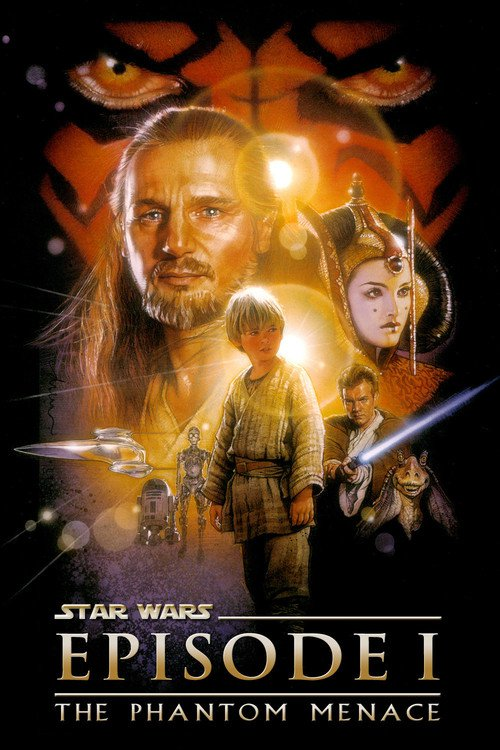

In [45]:
display_similar(2628, num=5)

So we see that people who like Star Wars tend like other sci-fi movies (including other Star Wars films), as well as some action and drama.

> _Note_ since we are using a very small dataset, results may not be as good as those for the same model trained on a larger dataset.

Now you will see the power and flexibility that comes from using a search engine to generate recommendations. Solr allows you to tweak the results returned by the recommendation query using any standard search query or filter - from free text search through to filters based on time and geo-location (or any other piece of metadata you can think of).

For example, perhaps you want to remove any movies with "matrix" in the title from the recommendations. You can do this by simply passing a valid Solr query string to the recommendation function.

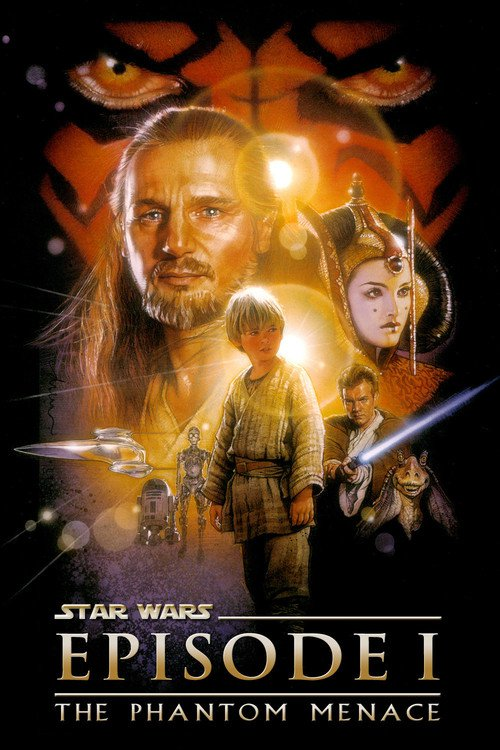

In [46]:
display_similar(2628, num=5, q='NOT(title:matrix)')

Or you may want to ensure that only valid children's movies are shown to young viewers.

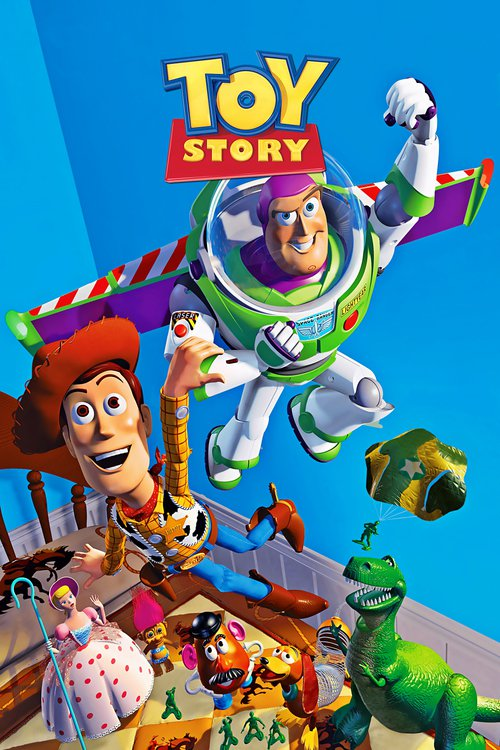

In [47]:
display_similar(1, num=5, q="genres:children")

Feel free to check out the documentation for the Solr [query string query](https://lucene.apache.org/solr/guide/6_6/searching.html) and play around with the various queries you can construct by passing in a query string as `q` in the recommendation function above!

### 5(b) Find movies to recommend to a user

Now, you're ready to generate some movie recommendations, personalized for a specific user.

Given a user, you can recommend movies to that user based on the predicted ratings from your model. In a similar manner to the similar movie recommendations, this predicted rating score is computed from the model factor vector for the user and the factor vectors for each movie. Recall that the collaborative filtering model means that, at a high level, we will recommend movies _liked by other users who liked the same movies as the given user_.

In [48]:
display_user_recs(12, num=5, num_last=5)

Again, note that since we are using a very small dataset, the results may not be too good. However, we can see that this user seems to like some sci-fi, some horror and some comedy films. The recommended movies fall broadly into these categories and seem to be somewhat reasonable.

Next, you can again apply the power of Solr's filtering capabilities to your recommendation engine. Let's say you only want to recommend more recent movies (say, from the past 5 years). This can be done by adding a date math query to the recommendation function query.

In [49]:
display_user_recs(12, num=5, num_last=5, q="release_date:[2012 TO *]")

You can see that the recommendation include only recent movies, and this time they seem to be heavily tilted to sci-fi and fantasy genres.

As you did with the similar movies recommendations, feel free to play around with the various queries you could pass into the user recommendation query.